In [2]:
# Cleaned & Parallelized Preprocessing Pipeline for MIMIC-III Symptom Extraction
import pandas as pd
import re
import spacy
from scispacy.umls_linking import UmlsEntityLinker
from tqdm import tqdm
import matplotlib.pyplot as plt
import multiprocessing

# ----------------------------
# Step 1: Load and Filter Discharge Summaries
# ----------------------------
noteevents = pd.read_csv("NOTEEVENTS.csv.gz", 
                         usecols=["SUBJECT_ID", "HADM_ID", "CHARTDATE", "CATEGORY", "TEXT"],
                         compression="gzip", low_memory=False)

discharge_notes = noteevents[noteevents["CATEGORY"] == "Discharge summary"].copy()
print(f"Loaded {len(discharge_notes)} discharge summaries.")

Loaded 59652 discharge summaries.


In [3]:
# ----------------------------
# Step 2: Extract Relevant Clinical Sections
# ----------------------------
RELEVANT_HEADERS = {
    'HISTORY OF PRESENT ILLNESS', 'IMPRESSION', 'FINDINGS',
    'HOSPITAL COURSE', 'PHYSICAL EXAMINATION', 'CHIEF COMPLAINT'
}

def extract_sections(text):
    sections = {}
    current_section = None
    lines = text.split('\n')
    for line in lines:
        line_stripped = line.strip()
        if re.match(r'^[A-Z][A-Z \-]*:$', line_stripped):
            current_section = line_stripped[:-1].strip()
            sections[current_section] = []
        elif current_section:
            sections[current_section].append(line_stripped)
    kept = []
    for key in sections:
        if any(rel in key for rel in RELEVANT_HEADERS):
            kept.extend(sections[key])
    return ' '.join(kept).strip()

discharge_notes["TEXT_CLEAN"] = discharge_notes["TEXT"].fillna("").apply(extract_sections)
discharge_notes = discharge_notes[discharge_notes["TEXT_CLEAN"].str.len() > 0].copy()
print("Cleaned and extracted relevant sections.")

Cleaned and extracted relevant sections.


In [4]:
# ----------------------------
# Step 3: Load SciSpaCy Model and UMLS Linker
# ----------------------------
print("Loading en_core_sci_lg model...")
nlp = spacy.load("en_core_sci_lg")
print("Adding UMLS linker to pipeline...")
nlp.add_pipe("scispacy_linker", config={"resolve_abbreviations": True, "linker_name": "umls"})
linker = nlp.get_pipe("scispacy_linker")
print("Pipeline components:", nlp.pipe_names)

Loading en_core_sci_lg model...


C:\Users\Allen\anaconda3\envs\disease_bilstm\lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_core_sci_lg' (0.5.1) was trained with spaCy v3.4.1 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Adding UMLS linker to pipeline...


C:\Users\Allen\anaconda3\envs\disease_bilstm\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.1.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Allen\anaconda3\envs\disease_bilstm\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.1.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Pipeline components: ['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer', 'parser', 'ner', 'scispacy_linker']


In [6]:
# ----------------------------
# Step 4: Efficient UMLS Symptom Extraction (Parallel)
# ----------------------------
def extract_umls_symptoms(doc):
    symptoms = set()
    for ent in doc.ents:
        for umls_ent in ent._.kb_ents:
            cui_entry = linker.kb.cui_to_entity.get(umls_ent[0])
            if cui_entry and "T184" in cui_entry.types:
                symptoms.add(cui_entry.canonical_name.lower())
    return list(symptoms)

print("Running symptom extraction on all notes (parallel)...")
texts = discharge_notes["TEXT_CLEAN"].tolist()
symptom_lists = []

n_cores = min(32, multiprocessing.cpu_count())
for doc in tqdm(nlp.pipe(texts, batch_size=32, n_process=1), total=len(texts)):
    symptom_lists.append(extract_umls_symptoms(doc))

discharge_notes["SYMPTOMS"] = symptom_lists
print("Symptom extraction complete.")

Running symptom extraction on all notes (parallel)...


100%|██████████████████████████████████████████████████████████████| 12064/12064 [37:00<00:00,  5.43it/s]

Symptom extraction complete.


In [7]:
# ----------------------------
# Step 5: Load and Join with ICD-9 Labels, Filter to Top 50
# ----------------------------
diagnoses = pd.read_csv("DIAGNOSES_ICD.csv.gz", 
                        usecols=["HADM_ID", "ICD9_CODE"], 
                        compression="gzip", low_memory=False)
print(f"Loaded {len(diagnoses)} diagnosis entries.")

labeled = discharge_notes.merge(diagnoses, on="HADM_ID", how="inner")
top_50 = labeled["ICD9_CODE"].value_counts().nlargest(50).index
labeled_filtered = labeled[labeled["ICD9_CODE"].isin(top_50)].copy()

# Only keep one diagnosis per HADM_ID for classification
labeled_filtered = labeled_filtered.sort_values(["HADM_ID", "ICD9_CODE"])
labeled_filtered = labeled_filtered.drop_duplicates("HADM_ID")
print(f"Filtered to top 50 diagnoses: {labeled_filtered['ICD9_CODE'].nunique()} classes")

Loaded 651047 diagnosis entries.
Filtered to top 50 diagnoses: 49 classes


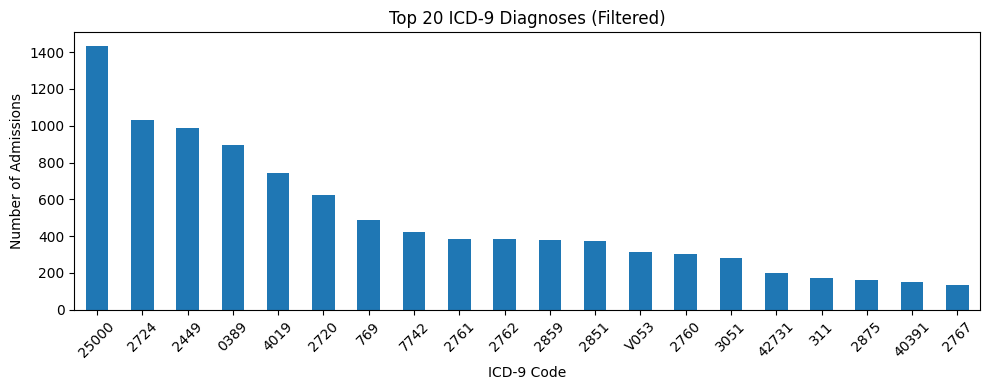

Saved preprocessed data to: labeled_notes_with_symptoms.csv


In [8]:
# ----------------------------
# Step 6: Visualize and Save Output
# ----------------------------
diagnosis_counts = labeled_filtered["ICD9_CODE"].value_counts().head(20)
plt.figure(figsize=(10, 4))
diagnosis_counts.plot(kind="bar")
plt.title("Top 20 ICD-9 Diagnoses (Filtered)")
plt.xlabel("ICD-9 Code")
plt.ylabel("Number of Admissions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

output_path = "labeled_notes_with_symptoms.csv"
labeled_filtered[["HADM_ID", "SYMPTOMS", "ICD9_CODE"]].to_csv(output_path, index=False)
print(f"Saved preprocessed data to: {output_path}")